In [1]:
import warnings
import pyfolio as pf
from openbb import obb
import pandas as pd
obb.user.preferences.output_type="dataframe"
warnings.filterwarnings("ignore")


/Users/vaibhav/anaconda3/envs/my_quant_lab/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# close=obb.equity.price.historical(
#     "AAPL",
#     start_date="2010-01-01",
#     end_date="2024-07-31",
#     provider="yfinance"
    
# ).close

close=obb.equity.price.historical(
    "AAPL",
    start_date="2010-01-01",
    end_date="2025-07-31",
    provider="yfinance"
).close


<Axes: xlabel='date'>

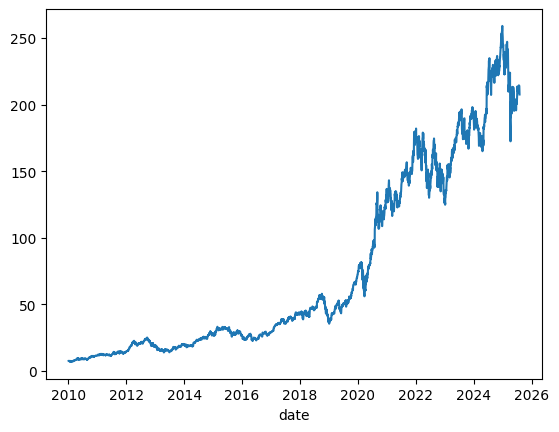

In [3]:
close.plot()

<Axes: xlabel='date'>

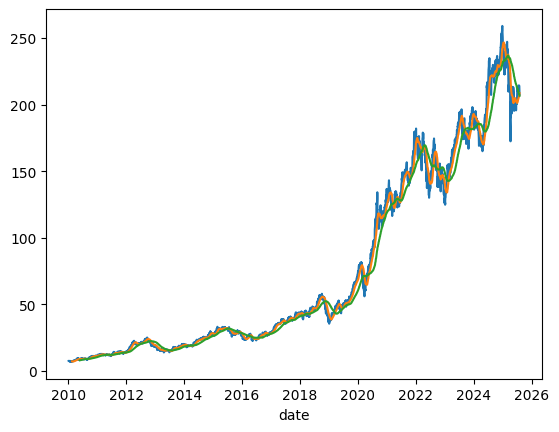

In [4]:
close.plot()
close.rolling(30).mean().plot()
close.rolling(100).mean().plot()
# close.rolling(300).mean().plot()

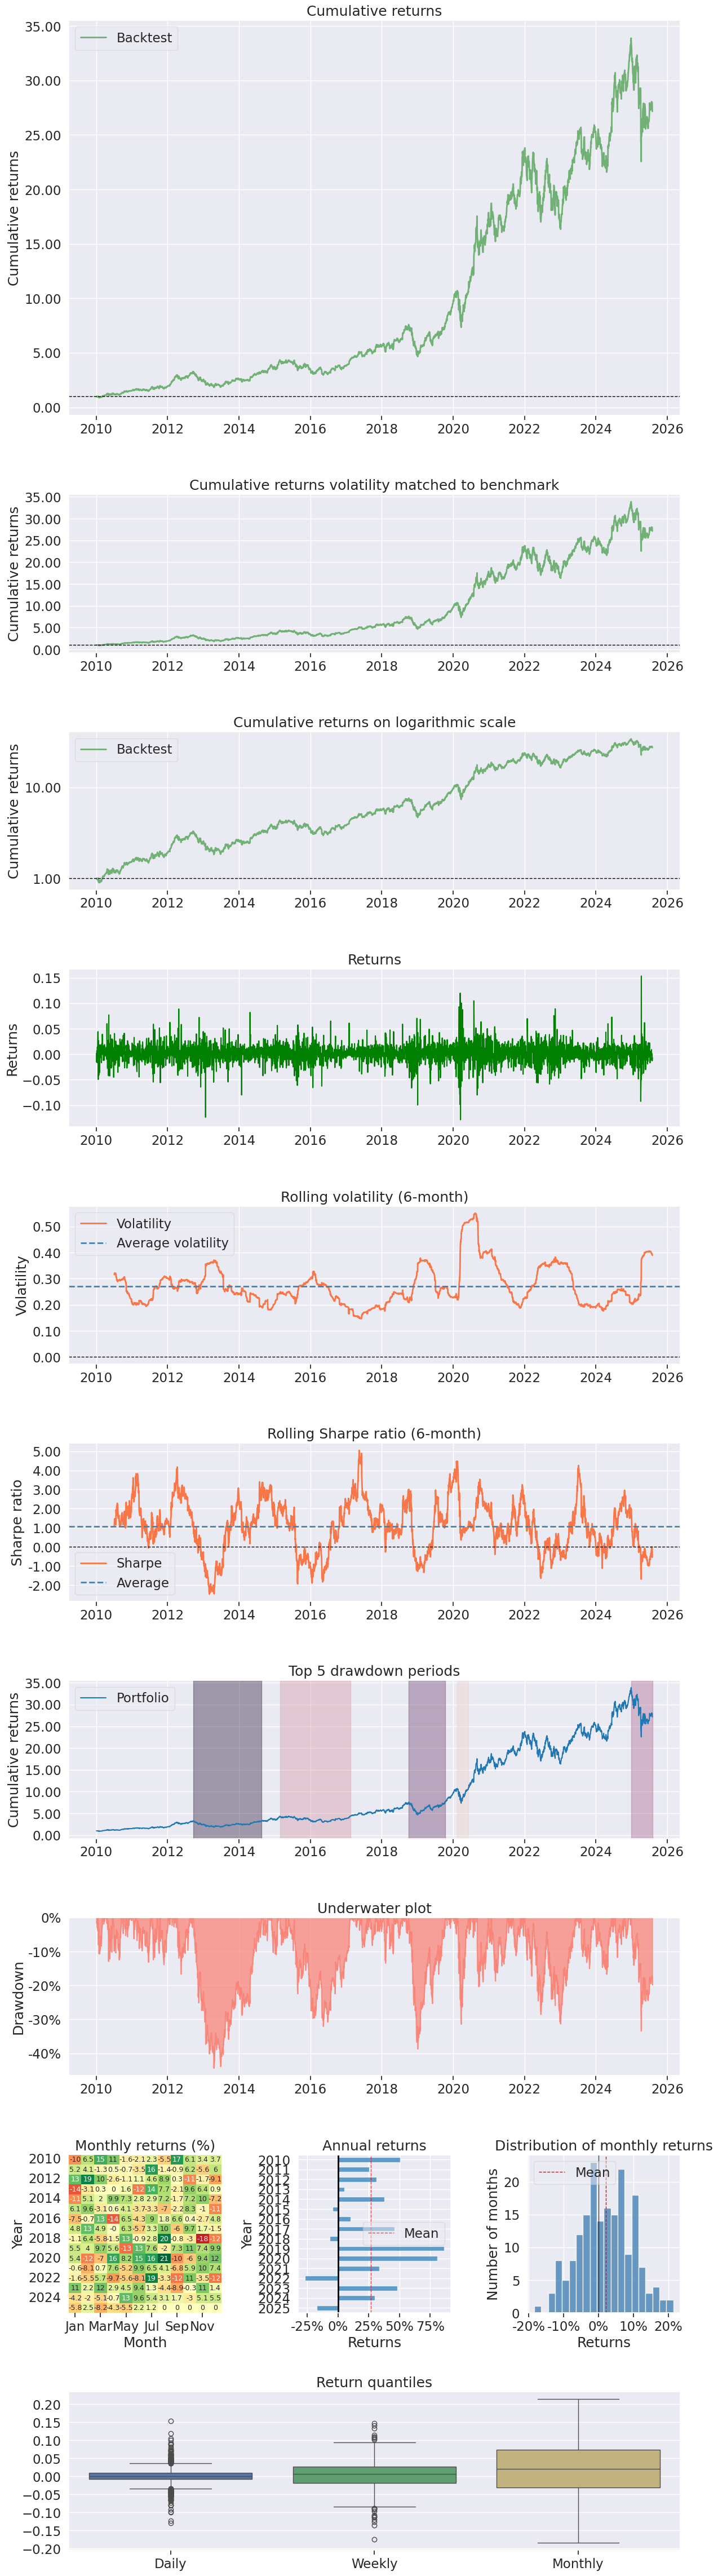

In [5]:
returns=close.pct_change()
returns.index=pd.to_datetime(returns.index)
pf.create_full_tear_sheet(returns)


In [6]:
from threading import Thread
from ibapi.client import EClient
from ibapi.wrapper import EWrapper

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

app = IBapi()
app.connect("127.0.0.1", 7497, clientId=1)
Thread(target=app.run, daemon=True).start()

ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002


In [7]:
# from threading import Thread
# from ibapi.client import EClient
# from ibapi.wrapper import EWrapper

# class IBapi(EWrapper, EClient):
#     def __init__(self):
#         EClient.__init__(self, self)

# app = IBapi()
# app.connect("127.0.0.1", 7497, clientId=1)
# Thread(target=app.run, daemon=True).start()

In [8]:
app.disconnect()

Step 2: Write the Minimum Viable Python with pandas


In [9]:
import warnings
import pandas as pd
import numpy as np
import pyfolio as pf
from openbb import obb
obb.user.preferences.output_type="dataframe"
warnings.filterwarnings("ignore")


In [10]:
#This is the number of days we will look back to
# calculate the rolling z-score

window = 22
#This is the number of standard deviatio the 
#z-score need to be above or below to trigger
# a trading signal

thresh = 2

#set the start date to today and end day to 
#two calendar years ago

today = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date=(pd.Timestamp.today()-pd.Timedelta(days=365*2)).strftime("%Y-%m-%d")

In [11]:
today
start_date

'2023-08-20'

Data Fetching

In [12]:
#Create a simple helper function to grab futures data.
def fetch_futures_from_openbb(ticker, start_date, end_date, expiry=None):
    data = obb.derivatives.futures.historical(ticker,start_date,end_date,provider="yfinance")
    data.rename(columns={"close":ticker},inplace=True)
    data.index = pd.to_datetime(data.index)
    data.index = data.index.normalize()
    return data[ticker]
    

In [13]:
#openBB provides access to individial futures data which is fine
# for our strategy, This is heating oil,gasoline, and crude oil
#futures data.

ho =  fetch_futures_from_openbb("HO=F", start_date,today)
rb =  fetch_futures_from_openbb("RB=F", start_date,today)
cl =  fetch_futures_from_openbb("CL=F", start_date,today)

# Get the refiener stock data for the same time range

psx= obb.equity.price.historical(
    "PSX",
    start_date=start_date,
    end_date=today,
    provider="yfinance"   
).close

psx.name="PSX"
#now put all the series together
data=pd.concat([ho,rb,cl,psx],axis=1).dropna()


In [14]:
data

HO=F    RB=F       CL=F         PSX
date                                             
2023-08-21  3.1162  2.7726  80.720001  113.330002
2023-08-22  3.1388  2.7891  80.349998  112.940002
2023-08-23  3.1291  2.7688  78.889999  112.260002
2023-08-24  3.1564  2.7800  79.050003  112.389999
2023-08-25  3.3075  2.8764  79.830002  113.889999
...            ...     ...        ...         ...
2025-08-13  2.2428  2.0704  62.650002  122.580002
2025-08-14  2.2345  2.1092  63.959999  122.730003
2025-08-15  2.2250  2.0725  62.799999  123.610001
2025-08-18  2.2403  2.0987  63.419998  122.839996
2025-08-19  2.2568  2.0896  62.720001  122.169998

[501 rows x 4 columns]

In [15]:
# Create a simple helper function to grab futures data.
def fetch_futures_from_openbb(ticker, start_date, end_date, expiry=None):
    data = obb.derivatives.futures.historical(ticker, start_date, end_date, provider="yfinance")
    data.rename(columns={"close": ticker}, inplace=True)
    data.index = pd.to_datetime(data.index)
    data.index = data.index.normalize()
    return data[ticker]

# OpenBB provides access to individual futures data which is fine
# for our strategy. This is heating oil, gasoline, and crude oil
# futures data.
ho = fetch_futures_from_openbb("HO=F", start_date, today)
rb = fetch_futures_from_openbb("RB=F", start_date, today)
cl = fetch_futures_from_openbb("CL=F", start_date, today)

# Get the refiner stock data for the same time range.
psx = obb.equity.price.historical(
    "PSX", 
    start_date=start_date, 
    end_date=today,
    provider="yfinance"
).close
psx.name = "PSX"

# Now put all the prices together.
data = pd.concat([ho, rb, cl, psx], axis=1).dropna()

In [16]:
#compute the price per barrel
rb *= 42
ho *=42

#construct the crack spread
data["crack_spread"] =2 * rb + ho- 3 * cl
data["crack_spread"] /=3

# Gasoline (rb) and Heating Oil (ho) futures are quoted in $/gallon.
# Crude Oil (cl) futures are quoted in $/barrel.
# gallon * 42 = barrel

In [17]:
data

HO=F    RB=F       CL=F         PSX  crack_spread
date                                                           
2023-08-21  3.1162  2.7726  80.720001  113.330002     40.539597
2023-08-22  3.1388  2.7891  80.349998  112.940002     41.687998
2023-08-23  3.1291  2.7688  78.889999  112.260002     42.443802
2023-08-24  3.1564  2.7800  79.050003  112.389999     42.979596
2023-08-25  3.3075  2.8764  79.830002  113.889999     47.014196
...            ...     ...        ...         ...           ...
2025-08-13  2.2428  2.0704  62.650002  122.580002     26.720398
2025-08-14  2.2345  2.1092  63.959999  122.730003     26.380600
2025-08-15  2.2250  2.0725  62.799999  123.610001     26.379999
2025-08-18  2.2403  2.0987  63.419998  122.839996     26.707802
2025-08-19  2.2568  2.0896  62.720001  122.169998     27.384000

[501 rows x 5 columns]

<Axes: xlabel='date'>

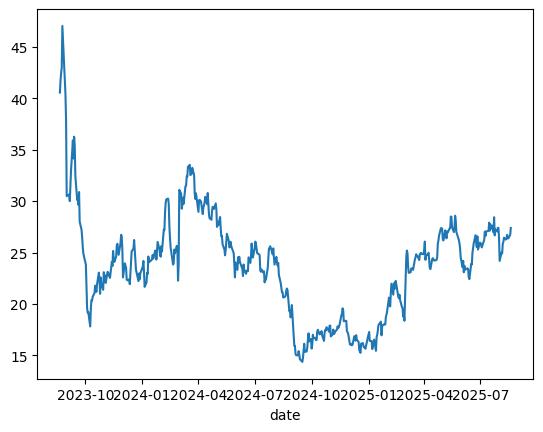

In [18]:
data.crack_spread.plot()

In [19]:
data['spread']=data.crack_spread-data.PSX

In [20]:
data

HO=F    RB=F       CL=F         PSX  crack_spread     spread
date                                                                      
2023-08-21  3.1162  2.7726  80.720001  113.330002     40.539597 -72.790405
2023-08-22  3.1388  2.7891  80.349998  112.940002     41.687998 -71.252004
2023-08-23  3.1291  2.7688  78.889999  112.260002     42.443802 -69.816200
2023-08-24  3.1564  2.7800  79.050003  112.389999     42.979596 -69.410404
2023-08-25  3.3075  2.8764  79.830002  113.889999     47.014196 -66.875803
...            ...     ...        ...         ...           ...        ...
2025-08-13  2.2428  2.0704  62.650002  122.580002     26.720398 -95.859603
2025-08-14  2.2345  2.1092  63.959999  122.730003     26.380600 -96.349403
2025-08-15  2.2250  2.0725  62.799999  123.610001     26.379999 -97.230001
2025-08-18  2.2403  2.0987  63.419998  122.839996     26.707802 -96.132194
2025-08-19  2.2568  2.0896  62.720001  122.169998     27.384000 -94.785998

[501 rows x 6 columns]

In [21]:
data['return']=np.log(data.spread/data.spread.shift(1))
data.head(5)

HO=F    RB=F       CL=F         PSX  crack_spread     spread  \
date                                                                         
2023-08-21  3.1162  2.7726  80.720001  113.330002     40.539597 -72.790405   
2023-08-22  3.1388  2.7891  80.349998  112.940002     41.687998 -71.252004   
2023-08-23  3.1291  2.7688  78.889999  112.260002     42.443802 -69.816200   
2023-08-24  3.1564  2.7800  79.050003  112.389999     42.979596 -69.410404   
2023-08-25  3.3075  2.8764  79.830002  113.889999     47.014196 -66.875803   

              return  
date                  
2023-08-21       NaN  
2023-08-22 -0.021361  
2023-08-23 -0.020357  
2023-08-24 -0.005829  
2023-08-25 -0.037200

In [22]:
data['z']=(data.spread-data.spread.rolling(window=window).mean())/data.spread.rolling(window=window).std()

In [23]:
data.tail()

HO=F    RB=F       CL=F         PSX  crack_spread     spread  \
date                                                                         
2025-08-13  2.2428  2.0704  62.650002  122.580002     26.720398 -95.859603   
2025-08-14  2.2345  2.1092  63.959999  122.730003     26.380600 -96.349403   
2025-08-15  2.2250  2.0725  62.799999  123.610001     26.379999 -97.230001   
2025-08-18  2.2403  2.0987  63.419998  122.839996     26.707802 -96.132194   
2025-08-19  2.2568  2.0896  62.720001  122.169998     27.384000 -94.785998   

              return         z  
date                            
2025-08-13  0.022686  0.407803  
2025-08-14  0.005097  0.152166  
2025-08-15  0.009098 -0.195408  
2025-08-18 -0.011355  0.229565  
2025-08-19 -0.014103  0.711683

In [24]:
thresh
data["position"] = np.select(
    [data.z < - thresh,data.z > thresh],
    [1,-1],
    default=0    
)


In [25]:
data[data.position >0]

HO=F    RB=F       CL=F         PSX  crack_spread      spread  \
date                                                                          
2023-11-02  3.0255  2.2460  82.459999  118.120003     22.785003  -95.335000   
2023-11-30  2.8305  2.1998  75.959999  128.889999     25.261400 -103.628600   
2023-12-01  2.6615  2.1211  74.070000  129.699997     22.581799 -107.118198   
2023-12-04  2.6597  2.1342  73.040001  128.440002     23.953401 -104.486602   
2024-01-30  2.8068  2.2607  77.820000  142.410004     24.774798 -117.635205   
2024-01-31  2.8082  2.1833  75.849998  144.309998     24.597200 -119.712797   
2024-03-15  2.7270  2.7208  81.040001  159.029999     33.320397 -125.709602   
2024-03-28  2.6156  2.7611  83.169998  163.339996     30.759205 -132.580791   
2024-04-01  2.6271  2.7100  83.709999  163.339996     28.949402 -134.390594   
2024-04-02  2.7119  2.7589  85.150002  169.490005     30.065796 -139.424209   
2024-04-03  2.7324  2.7609  85.430000  172.710007     30.128799 -142.581207   
2024-07-30  2.3368  2.3871  74.730003  147.169998     24.823997 -122.346001   
2024-10-03  2.2947  2.0926  73.709999  138.929993     17.008603 -121.921390   
2024-10-04  2.3127  2.0958  74.379997  138.619995     16.680201 -121.939794   
2024-12-02  2.1777  1.9172  68.099998  136.429993     16.069401 -120.360591   
2025-02-11  2.5146  2.1473  73.320000  129.550003     22.008801 -107.541202   
2025-02-18  2.4406  2.0867  71.849998  130.279999     20.745999 -109.533999   
2025-05-09  2.0664  2.1084  61.020000  110.919998     26.944803  -83.975195   
2025-05-12  2.1111  2.1331  61.950001  118.680000     27.332200  -91.347801   
2025-05-13  2.1713  2.1660  63.669998  125.570000     27.376198  -98.193802   
2025-05-14  2.2061  2.1700  63.150002  124.699997     28.495400  -96.204597   
2025-07-10  2.3835  2.1524  66.570000  134.389999     27.066202 -107.323797   

              return         z  position  
date                                      
2023-11-02  0.015433 -2.008251         1  
2023-11-30  0.079593 -3.437196         1  
2023-12-01  0.033120 -3.104932         1  
2023-12-04 -0.024874 -2.122806         1  
2024-01-30  0.033169 -2.086064         1  
2024-01-31  0.017507 -2.188246         1  
2024-03-15  0.029753 -2.261356         1  
2024-03-28  0.029257 -2.162981         1  
2024-04-01  0.013558 -2.120493         1  
2024-04-02  0.036771 -2.428050         1  
2024-04-03  0.022391 -2.430280         1  
2024-07-30  0.058955 -2.474693         1  
2024-10-03  0.029178 -2.858160         1  
2024-10-04  0.000151 -2.378948         1  
2024-12-02  0.029563 -2.010611         1  
2025-02-11  0.045091 -2.178185         1  
2025-02-18  0.034707 -2.319699         1  
2025-05-09  0.021989 -2.108701         1  
2025-05-12  0.084153 -3.071736         1  
2025-05-13  0.072269 -3.157827         1  
2025-05-14 -0.020466 -2.319236         1  
2025-07-10  0.032422 -2.290131         1

In [26]:
strategy_returns = data.position.shift(1) * data["return"]

In [27]:
strategy_returns.index=pd.to_datetime(strategy_returns.index)



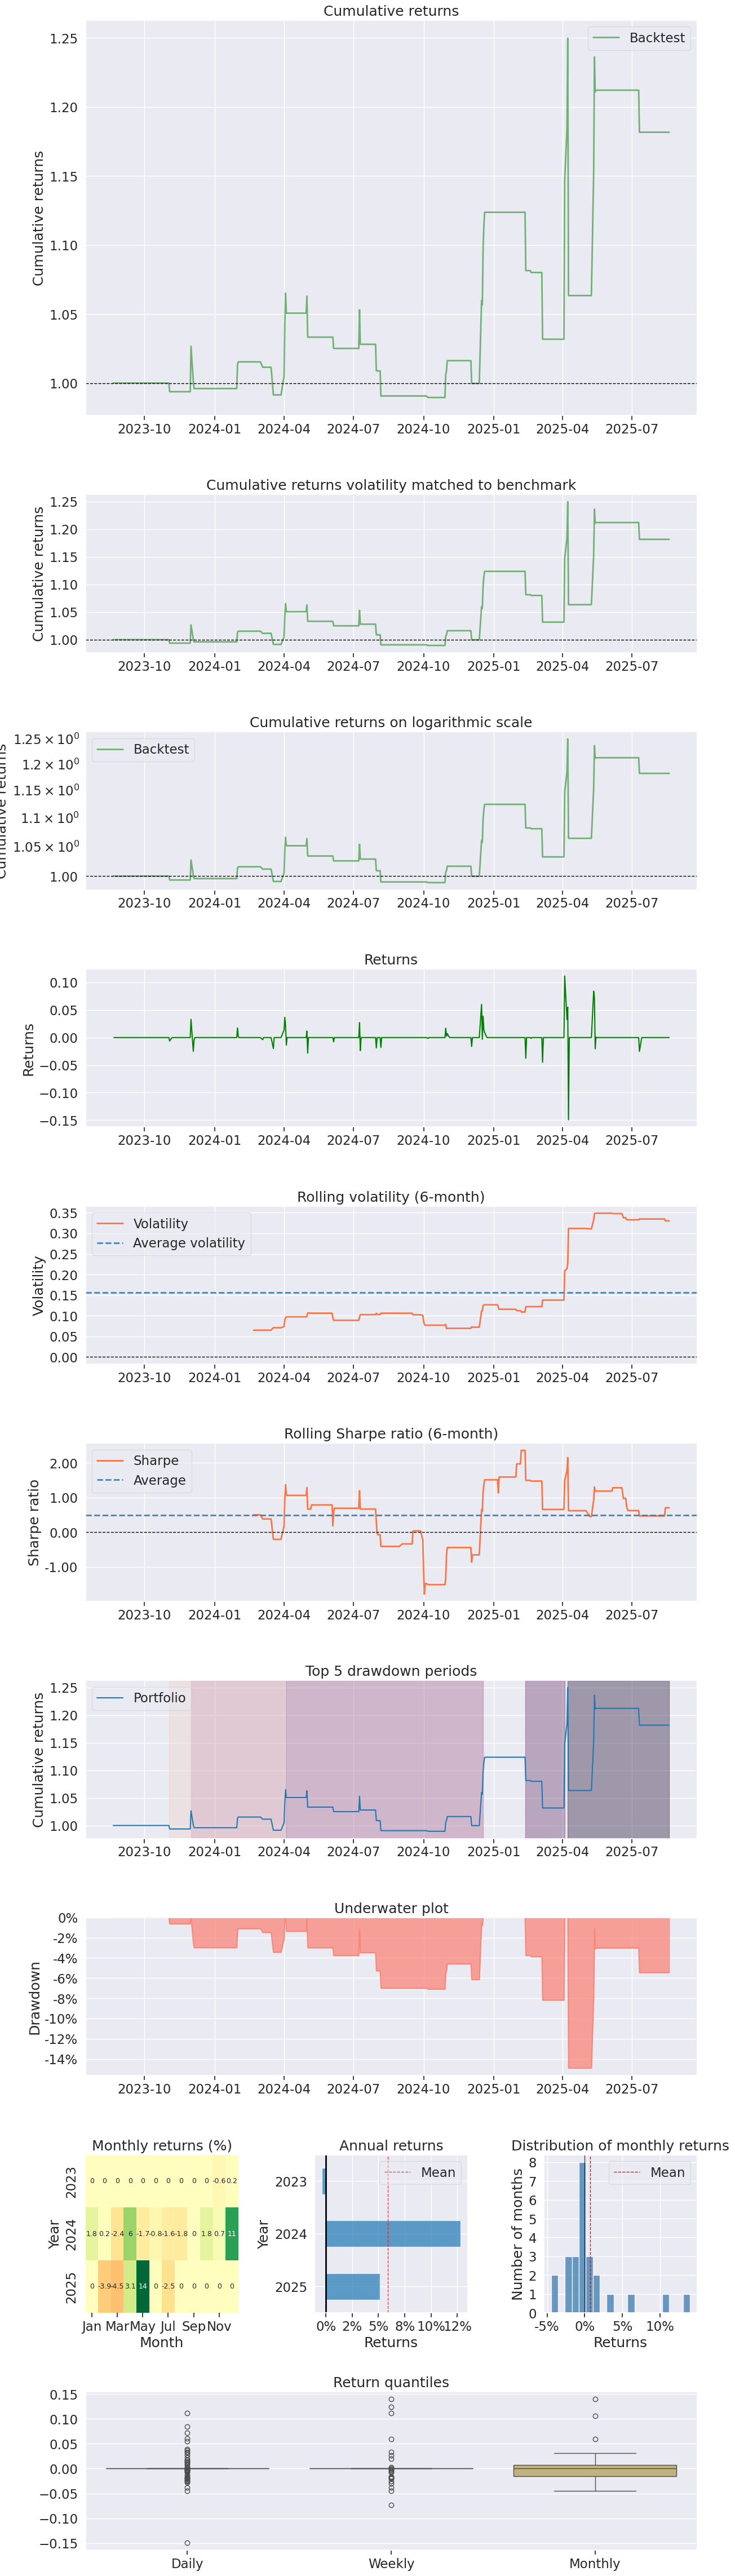

In [28]:
pf.create_full_tear_sheet(strategy_returns)

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

Step 3: Write the Minimum Viable Python with pandas
Backtest your strategy idea using VectorBT

In [29]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import vectorbt as vbt



In [30]:
# This is the number of days we'll look back to 
# calculate the rolling z-score.
window = 22

# This is the number of standard deviations the 
# z-score needs to be above or below to trigger
# a trading signal.`
thresh = 2

In [31]:
# Use the VectorBT data download functionality to
# grab price history data.
data = vbt.YFData.download(
    [
        "CL=F", 
        "RB=F", 
        "HO=F", 
        "PSX"
    ], 
    start="2020-01-01 UTC", 
    end="2023-12-31 UTC",
    missing_index="drop"
)

crack_spread=0

In [32]:
# The data object requires us to extract the data.
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
psx = data.get("Close")["PSX"]

In [33]:
rb

Date
2020-01-02 05:00:00+00:00    1.7042
2020-01-03 05:00:00+00:00    1.7488
2020-01-06 05:00:00+00:00    1.7544
2020-01-07 05:00:00+00:00    1.7222
2020-01-08 05:00:00+00:00    1.6488
                              ...  
2023-12-22 05:00:00+00:00    2.1301
2023-12-26 05:00:00+00:00    2.1583
2023-12-27 05:00:00+00:00    2.1550
2023-12-28 05:00:00+00:00    2.0852
2023-12-29 05:00:00+00:00    2.1026
Name: RB=F, Length: 1006, dtype: float64

In [34]:
#compute price per barrel for RBOB gasoline(rb) from per Gallon by Multiplying by 42
#compute price per barrel for heating oil (ho) from per Gallon by Multiplying by 42
#price of WTI crude is already quoted in dollars per barrel
# lastly at the end we need to divide by 3 to get price per barrel insread of 3 barrels

#compute price per barrel
rb *=42
ho *=42

# construct the crack spread
crack_spread =  2 * rb + ho - 3 * cl
crack_spread /= 3 

In [35]:
spread = crack_spread - psx

In [36]:
zscore= (
spread- spread.rolling(window=window).mean())/spread.rolling(window=window).std()
    


In [37]:
zscore

Date
2020-01-02 05:00:00+00:00         NaN
2020-01-03 05:00:00+00:00         NaN
2020-01-06 05:00:00+00:00         NaN
2020-01-07 05:00:00+00:00         NaN
2020-01-08 05:00:00+00:00         NaN
                               ...   
2023-12-22 05:00:00+00:00   -1.401028
2023-12-26 05:00:00+00:00   -1.729728
2023-12-27 05:00:00+00:00   -1.318629
2023-12-28 05:00:00+00:00   -1.047031
2023-12-29 05:00:00+00:00   -1.013201
Length: 1006, dtype: float64

In [38]:
long_entries =  zscore.vbt.crossed_below(-thresh)
long_exits = zscore.vbt.crossed_above(thresh)

In [39]:
fig = zscore.vbt.plot()
fig.add_hline(y=thresh, line_color="orangered",line_dash="dot")
fig.add_hline(y=0, line_color="yellow",line_dash="dot")
fig.add_hline(y=-thresh, line_color="limegreen",line_dash="dot")
fig.show()              




In [40]:
#Run a backtest based on the prices, long, and short entries and exists
perf =  vbt.Portfolio.from_signals(
    psx,
    entries=long_entries,
    exits=long_exits,
    freq="1D"

)
    


<Axes: xlabel='Date'>

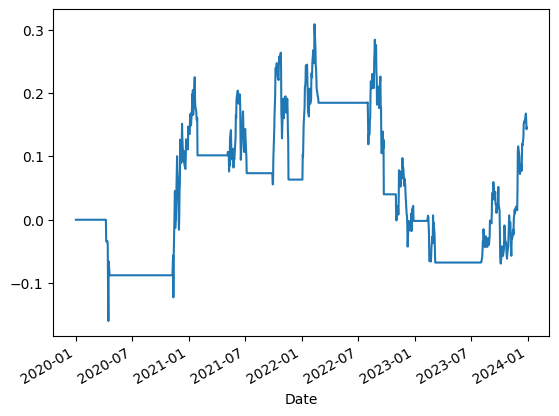

In [41]:
perf.cumulative_returns().plot()

In [42]:
perf.stats()

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    114.539426
Total Return [%]                              14.539426
Benchmark Return [%]                          41.864851
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              28.862356
Max Drawdown Duration                 472 days 00:00:00
Total Trades                                          9
Total Closed Trades                                   8
Total Open Trades                                     1
Open Trade PnL                                21.290539
Win Rate [%]                                       25.0
Best Trade [%]                                20.734029
Worst Trade [%]                                -

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

Step 4: Assess the risk and performance metrics 

In [43]:
print(f"The Sharpe Ratio of the backtest is :{perf.sharpe_ratio()}")

The Sharpe Ratio of the backtest is :0.3177879449361286


In [45]:
print(f"The maximum drawdown of the backtest is : {perf.max_drawdown()}")

The maximum drawdown of the backtest is : -0.28862356364445774


In [47]:
perf.plot_cum_returns()

FigureWidget({
    'data': [{'line': {'color': '#7f7f7f'},
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': '06923024-85ca-47f6-b4d8-a5d4c3df7159',
              'x': array([datetime.datetime(2020, 1, 2, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 3, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 5, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([1.        , 0.96693403, 0.96087363, ..., 1.43527078, 1.41545178,
                          1.41864851])},
             {'hoverinfo': 'skip',
 

In [48]:
#Drawdown Plots
perf.plot_drawdowns()


FigureWidget({
    'data': [{'line': {'color': '#9467bd'},
              'name': 'Value',
              'showlegend': True,
              'type': 'scatter',
              'uid': '8b2b195a-a75c-442b-9db0-0571f9ce99a6',
              'x': array([datetime.datetime(2020, 1, 2, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 3, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 5, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([100.        , 100.        , 100.        , ..., 115.88148182,
                          114.28132709, 114.53942569])},
             {'customdata': 

In [49]:
perf.plot_underwater()

FigureWidget({
    'data': [{'fill': 'tozeroy',
              'fillcolor': 'rgba(220,57,18,0.3000)',
              'line': {'color': '#dc3912'},
              'name': 'Drawdown',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ce1cbe4c-a2ed-4b68-b138-39cef63286b4',
              'x': array([datetime.datetime(2020, 1, 2, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 3, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 5, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([ 0.        ,  0.        ,  0.        , ..., -0.11437324, 

In [50]:
perf.plot_trades()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '508ce191-1f84-4562-80f8-973fc8486458',
              'x': array([datetime.datetime(2020, 1, 2, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 3, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 5, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([ 89.20258331,  86.25301361,  85.71240997, ..., 128.02986145,
                          126.26195526, 126.54711151])},
             {'customdata': 

In [ ]:
# Drawdown Plots
perf.plot_trades()